<a href="https://colab.research.google.com/github/abdulganiyMK007/freeCodeCamp-Project-Files/blob/master/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 625.6/625.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.0 MB/s eta 0:00:00
2.19.0-dev20241114


In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2024-11-15 14:08:17--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.005s  

2024-11-15 14:08:17 (74.5 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2024-11-15 14:08:18--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

## Setup input pipeline

In [6]:
train_dataset = pd.read_csv(train_file_path, sep="\t", header=None, names=["type", "msg"])
test_dataset = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])

In [7]:
print(train_dataset.shape)
print(test_dataset.shape)

(4179, 2)
(1392, 2)


In [8]:
train_dataset.head()

,type,msg
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [9]:
train_dataset['type'] = train_dataset['type'].map({'ham': 0, 'spam': 1})
test_dataset['type'] = test_dataset['type'].map({'ham': 0, 'spam': 1})

In [10]:
train_dataset.head()

,type,msg
0,0,ahhhh...just woken up!had a bad dream about u ...
1,0,you can never do nothing
2,0,"now u sound like manky scouse boy steve,like! ..."
3,0,mum say we wan to go then go... then she can s...
4,0,never y lei... i v lazy... got wat? dat day ü ...


In [11]:
BUFFER_SIZE = 250
BATCH_SIZE = 64

In [12]:
# Convert the DataFrame to a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
          tf.cast(train_dataset['msg'].values, tf.string),
          tf.cast(train_dataset['type'].values, tf.int32)
    )
)

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'


In [13]:
# Convert the DataFrame to a tf.data.Dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    (
          tf.cast(test_dataset['msg'].values, tf.string),
          tf.cast(test_dataset['type'].values, tf.int32)
    )
)

In [14]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
for msg, label in train_dataset.take(1):
    print('texts: ', msg.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b'wait.i will come out.. &lt;#&gt;  min:)'
 b'thanks for loving me so. you rock'
 b'they will pick up and drop in car.so no problem..']

labels:  [0 0 0]


## Create the text encoder

In [16]:
VOCAB_SIZE = 1000

encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
)

encoder.adapt(train_dataset.map(lambda text, label: text))


In [17]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'to', 'i', 'you', 'a', 'the', 'u', 'and', 'in', 'is',
       'me', 'my', 'for', 'your', 'of', 'it', 'call', 'have', 'on'],
      dtype='<U15')

In [18]:
encoded_example = encoder(msg)[:3].numpy()
encoded_example

array([[  1,  34,  60,  51,  48, 289,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [172,  13, 630,  11,  27,   4, 945,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [104,  34, 173,  43,   8, 596,   9,   1,  41, 335,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]])

In [19]:
for n in range(3):
  print("Original: ", msg[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'wait.i will come out.. &lt;#&gt;  min:)'
Round-trip:  [UNK] will come out ltgt min                                  

Original:  b'thanks for loving me so. you rock'
Round-trip:  thanks for loving me so you rock                                 

Original:  b'they will pick up and drop in car.so no problem..'
Round-trip:  they will pick up and drop in [UNK] no problem                              



## Create a Model

In [20]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [21]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Convert sample_text to a tf.Tensor of strings
sample_text_tensor = tf.convert_to_tensor([sample_text])

# Predict using the model
predictions = model.predict(sample_text_tensor)

# predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[0.49706423]


In [22]:
# predict on a sample text with padding

padding = "the " * 2000

# Convert sample_text to a tf.Tensor of strings
sample_text_tensor = tf.convert_to_tensor([sample_text, padding])

# Predict using the model
predictions = model.predict(sample_text_tensor)

# predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
[0.49706423]


In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train a Model

In [24]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:743: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.8414 - loss: 0.6749 - val_accuracy: 0.8657 - val_loss: 0.5805
Epoch 2/10
 2/66 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8711 - loss: 0.5805

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.8719 - loss: 0.5307 - val_accuracy: 0.8657 - val_loss: 0.4384
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.8702 - loss: 0.4017 - val_accuracy: 0.8671 - val_loss: 0.3068
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.8864 - loss: 0.2573 - val_accuracy: 0.9555 - val_loss: 0.1759
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.9673 - loss: 0.1466 - val_accuracy: 0.9670 - val_loss: 0.1258
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.9701 - loss: 0.1046 - val_accuracy: 0.9734 - val_loss: 0.0952
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9772 - loss: 0.0774 - val_accuracy: 0.9749 - val_loss: 0.0843
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9842 - loss: 0.0631 - val_accuracy: 0.9784 - val_loss: 0.0768
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9855 - loss: 0.0540 - val_accuracy: 0.9813 - v

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (1, None)                   │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (1, None, 64)               │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (1, 128)                    │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 64)                     │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 415,109 (1.58 MB)

 Trainable params: 138,369 (540.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 276,740 (1.06 MB)

In [26]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6835693154484034)

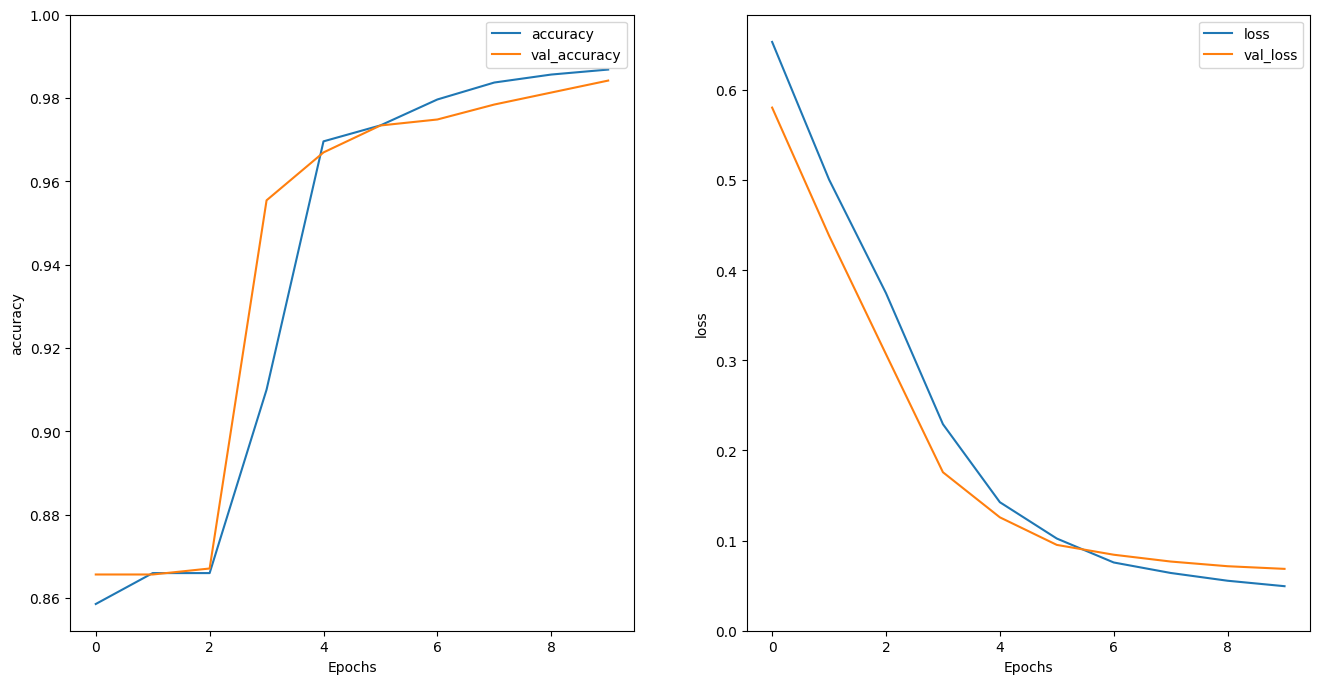

In [27]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [28]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9873 - loss: 0.0664
Test Loss: 0.06864140182733536
Test Accuracy: 0.9841954112052917


## Test Model

In [29]:
text_input = ["Your input text here"]
text_input_tensor = tf.convert_to_tensor(text_input)
predictions = model.predict(text_input_tensor)

# The predictions will be between 0 and 1
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
[[0.46842068]]


In [30]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    pred_text_tensor = tf.convert_to_tensor([pred_text])
    prediction = model.predict(pred_text_tensor)

    if prediction > 0.5:
        return [prediction, 'spam']
    else:
        return [prediction, 'ham']

In [31]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
You passed the challenge. Great job!
